<a href="https://colab.research.google.com/github/WVital2025/The-Approximation-Capability-of-Hypercomplex-Valued-Residual-Neural-Networks/blob/main/Regression_ResNet_4D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras.layers import Dense

In [ ]:
def ftrue(X):
    return np.stack([X[:,0]+X[:,1]*X[:,2]+X[:,3],
                     X[:,1]+X[:,2]*X[:,3]+X[:,0],
                     X[:,2]+X[:,3]*X[:,0]+X[:,1],
                     X[:,3]+X[:,0]*X[:,1]+X[:,2]
                    ],1)

In [ ]:
# t = np.linspace(-1,1,num=11)

# Xtr = []
# for x0 in t:
#     for x1 in t:
#         for x2 in t:
#             for x3 in t:
#                 Xtr.append([x0,x1,x2,x3])
# Xtr = np.array(Xtr)
# ytr = ftrue(Xtr)
# Xtr.shape,ytr.shape

In [ ]:
Xtr = 2*np.random.rand(20*256,4)-1.0
ytr = ftrue(Xtr)
Xtr.shape,ytr.shape

((5120, 4), (5120, 4))

# V-Dense Layers

In [ ]:
class V_Dense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 kernel_initializer="random_uniform",
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_Dense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.kernel_initializer=kernel_initializer
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        self.W = self.add_weight(
            shape=(input_dim, self.units,self.algdim),
            initializer=self.kernel_initializer,
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.reduce_sum(
            [tf.experimental.numpy.kron(self.algebra[i,:,:],self.W[:,:,i]) for i in range(self.algdim)]
            ,axis=0)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
class V_RealDense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 kernel_initializer="random_uniform",
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_RealDense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.kernel_initializer=kernel_initializer
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units),
            initializer=self.kernel_initializer,
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.experimental.numpy.kron(np.eye(self.algdim, dtype = np.float32),self.W)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

# Hyper-parameters

In [ ]:
# def scheduler(epoch, lr):
#     if epoch == 500:
#         return lr/2
#     else:
#         return lr

# callback = kr.callbacks.LearningRateScheduler(scheduler)

In [ ]:
Nhidden = 164 # 32, 50,101,152,164
Nepochs = 1000
opt_method = 'adam'

In [ ]:
def MeanAbs(y_true,y_pred):
    return tf.reduce_mean(tf.math.sqrt(tf.reduce_sum(tf.math.square(y_true-y_pred),axis=1)))

# Real-valued ResNet

In [ ]:
# Define the residual block.

class ResNetBlock(kr.layers.Layer):
    def __init__(self):
        super(ResNetBlock, self).__init__()

    def build(self, input_shape):
        self.Ub = kr.layers.Dense(1, activation='relu',use_bias = True,
                                  kernel_initializer=kr.initializers.RandomUniform()
                                 )
        self.V = kr.layers.Dense(input_shape[-1], activation=None, use_bias=False,
                                kernel_initializer=kr.initializers.RandomUniform()
                                )

    def call(self, inputs):
        return inputs + self.V(self.Ub(inputs))

In [ ]:
kr.backend.clear_session()

Layers = [ResNetBlock() for i in range(Nhidden)]
Layers.append(kr.layers.Dense(4, activation=None, use_bias = False))

R_ResNet = kr.Sequential(Layers)

R_ResNet.compile(optimizer=opt_method,loss='mse',metrics=[MeanAbs])
R_hist = R_ResNet.fit(Xtr,ytr,epochs=Nepochs, verbose = 1, batch_size=256)  #, callbacks=[callback])

R_ResNet.summary()

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 22ms/step - loss: 1.2994 - mean_abs: 2.1043
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 1.1091 - mean_abs: 1.9358
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8503 - mean_abs: 1.6839
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6848 - mean_abs: 1.4981
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5973 - mean_abs: 1.3846
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5154 - mean_abs: 1.2795
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4640 - mean_abs: 1.2077
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3911 - mean_abs: 1.1034
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3128 - mean_abs: 0.9838
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2430 - mean_abs: 0.8689
Epoch 11/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1910 - mean_abs: 0.7664
Epoch 12/1000
20/20 ━━━━━━━━━━━━━━━━━━━

KeyError: 'MeanAbs'

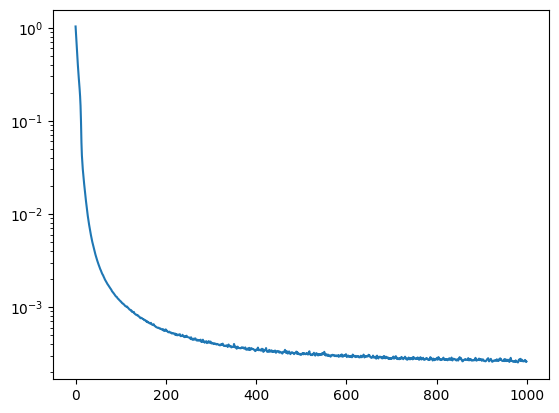

In [ ]:
# plt.figure(figsize=(8,6))
plt.semilogy(R_hist.history['loss'],label="MSE")
plt.semilogy(R_hist.history['MeanAbs'],label="MAE")

plt.grid()
plt.legend()

print("Loss: %2.2e" % R_hist.history['loss'][-1])
print("Error: %2.2e" % R_hist.history['MeanAbs'][-1])


In [ ]:
a=b

NameError: name 'b' is not defined

# V-Residual Block

In [ ]:
class V_ResNetBlock(kr.layers.Layer):
    def __init__(self,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        super(V_ResNetBlock, self).__init__()
        self.algebra = algebra

    def build(self, input_shape):
        self.Ub = V_Dense(1, activation='relu', algebra=self.algebra,
                        kernel_initializer=kr.initializers.RandomUniform())
        self.V = V_RealDense(input_shape[-1]//4, activation=None, use_bias=False,
                        algebra=self.algebra,
                        kernel_initializer=kr.initializers.RandomUniform())

    def call(self, inputs):
        return inputs + self.V(self.Ub(inputs))

In [ ]:
def EvalV_ResNet(
        algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1),
        Name = "C_ResNet2D",
        verbose = 0):

    kr.backend.clear_session()

    Layers = [V_ResNetBlock(algebra = algebra) for i in range(Nhidden)]
    Layers.append(V_RealDense(1, algebra = algebra, activation=None, use_bias = False))

    V_ResNet = kr.Sequential(Layers)

    V_ResNet.compile(optimizer=opt_method,loss='mse',metrics=[MeanAbs])
    hist = V_ResNet.fit(Xtr,ytr, epochs=Nepochs, verbose = verbose, batch_size=256) #, callbacks=[callback])

    if verbose>0:
        print(V_ResNet.summary())

    return V_ResNet, hist

# NonDegenerate Algebra (W)

In [ ]:
NonDegenerate = 1.0*np.stack([np.eye(4),np.eye(4),np.eye(4),np.eye(4)],axis=-1)

for i in range(4):
    print(NonDegenerate[:,:,i])

In [ ]:
W_ResNet,W_hist = EvalV_ResNet(algebra = NonDegenerate,Name="W_ResNet4D",verbose=1)

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 43ms/step - loss: 0.7822 - mean_abs: 1.6345
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.7600 - mean_abs: 1.6106
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.7462 - mean_abs: 1.5927
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6798 - mean_abs: 1.5187
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.4635 - mean_abs: 1.2212
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.4187 - mean_abs: 1.1408
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3956 - mean_abs: 1.0942
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3967 - mean_abs: 1.0907
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3940 - mean_abs: 1.0845
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3927 - mean_abs: 1.0795
Epoch 11/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3832 - mean_abs: 1.0644
Epoch 12/1000
20/20 ━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ v__res_net_block                │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_1              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_2              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_3              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_4              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_5              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_6              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_7              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_8              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_9              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_10             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_11             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_12             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_13             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_14             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_15             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_16             │ (256, 4)               │             

 Total params: 4,433 (17.32 KB)

 Trainable params: 1,477 (5.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,956 (11.55 KB)

None


# Quaternions

In [ ]:
Quaternions = 1.0*np.stack([np.array([[1,0,0,0],
                                      [0,-1,0,0],
                                      [0,0,-1,0],
                                      [0,0,0,-1]]),
                            np.array([[0,1,0,0],
                                      [1,0,0,0],
                                      [0,0,0,1],
                                      [0,0,-1,0]]),
                           np.array([[0,0,1,0],
                                     [0,0,0,-1],
                                     [1,0,0,0],
                                     [0,1,0,0]]),
                           np.array([[0,0,0,1],
                                     [0,0,1,0],
                                     [0,-1,0,0],
                                     [1,0,0,0]])],axis=-1)
for i in range(4):
    print(Quaternions[:,:,i])

In [ ]:
Q_ResNet,Q_hist = EvalV_ResNet(algebra = Quaternions,Name="Q_ResNet4D",verbose=1)

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 172s 39ms/step - loss: 0.7349 - mean_abs: 1.5819
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.7243 - mean_abs: 1.5707
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.6659 - mean_abs: 1.5024
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.5705 - mean_abs: 1.3822
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.3591 - mean_abs: 1.0787
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2316 - mean_abs: 0.8454
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1764 - mean_abs: 0.7353
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1295 - mean_abs: 0.6302
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0934 - mean_abs: 0.5363
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0695 - mean_abs: 0.4646
Epoch 11/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0557 - mean_abs: 0.4195
Epoch 12/1000
20/20 ━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ v__res_net_block                │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_1              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_2              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_3              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_4              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_5              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_6              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_7              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_8              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_9              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_10             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_11             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_12             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_13             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_14             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_15             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_16             │ (256, 4)               │             

 Total params: 4,433 (17.32 KB)

 Trainable params: 1,477 (5.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,956 (11.55 KB)

None


# Dual Complex Numbers

In [ ]:
DCN = 1.0*np.stack([np.array([[1,0,0,0],
                              [0,-1,0,0],
                              [0,0,0,0],
                              [0,0,0,0]]),
                            np.array([[0,1,0,0],
                                      [1,0,0,0],
                                      [0,0,0,0],
                                      [0,0,0,0]]),
                           np.array([[0,0,1,0],
                                     [0,0,0,-1],
                                     [1,0,0,0],
                                     [0,-1,0,0]]),
                           np.array([[0,0,0,1],
                                     [0,0,1,0],
                                     [0,1,0,0],
                                     [1,0,0,0]])],axis=-1)
for i in range(4):
    print(DCN[:,:,i])

[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
DC_ResNet,DC_hist = EvalV_ResNet(algebra = DCN,Name="DC_ResNet4D",verbose=1)

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 44ms/step - loss: 0.7856 - mean_abs: 1.6323
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.7538 - mean_abs: 1.6015
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6972 - mean_abs: 1.5387
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6041 - mean_abs: 1.4215
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3976 - mean_abs: 1.1383
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.2949 - mean_abs: 0.9792
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2651 - mean_abs: 0.9288
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2434 - mean_abs: 0.8916
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2191 - mean_abs: 0.8448
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1982 - mean_abs: 0.8032
Epoch 11/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1835 - mean_abs: 0.7695
Epoch 12/1000
20/20 ━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ v__res_net_block                │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_1              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_2              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_3              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_4              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_5              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_6              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_7              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_8              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_9              │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_10             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_11             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_12             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_13             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_14             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_15             │ (256, 4)               │             9 │
│ (V_ResNetBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v__res_net_block_16             │ (256, 4)               │             

 Total params: 4,433 (17.32 KB)

 Trainable params: 1,477 (5.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,956 (11.55 KB)

None


# Hyperbolic Quaternions

In [ ]:
HyperQuat = 1.0*np.stack([np.array([[1,0,0,0],
                                      [0,1,0,0],
                                      [0,0,1,0],
                                      [0,0,0,1]]),
                            np.array([[0,1,0,0],
                                      [1,0,0,0],
                                      [0,0,0,1],
                                      [0,0,-1,0]]),
                           np.array([[0,0,1,0],
                                     [0,0,0,-1],
                                     [1,0,0,0],
                                     [0,1,0,0]]),
                           np.array([[0,0,0,1],
                                     [0,0,1,0],
                                     [0,-1,0,0],
                                     [1,0,0,0]])],axis=-1)
for i in range(4):
    print(HyperQuat[:,:,i])

In [ ]:
HQ_ResNet,HQ_hist = EvalV_ResNet(algebra = HyperQuat,Name="HQ_ResNet4D",verbose=1)

# Plots and Errors

In [ ]:
plt.semilogy(R_hist.history['loss'],'-^',label="Real Numbers (R)",markevery=50)
plt.semilogy(W_hist.history['loss'],'-v',label="Non-Degenerate Algebra (W)",markevery=50)
plt.semilogy(Q_hist.history['loss'],'-o',label="Quaternions (Q)",markevery=50)
plt.semilogy(DC_hist.history['loss'],'-s',label="Dual Complex Numbers (DC)",markevery=50)
plt.semilogy(HQ_hist.history['loss'],'-d',label="Hyperbolic Quaternions (HQ)",markevery=50)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.savefig("Figures4D/Experiment_4D_MSE.pdf",bbox_inches='tight')

In [ ]:
plt.semilogy(R_hist.history['MeanAbs'],'-^',label="Real Numbers (R)",markevery=50)
plt.semilogy(A_hist.history['MeanAbs'],'-v',label="Non-Degenerate Algebra (A)",markevery=50)
plt.semilogy(C_hist.history['MeanAbs'],'-o',label="Complex Numbers (C)",markevery=50)
plt.semilogy(D_hist.history['MeanAbs'],'-s',label="Dual Numbers (D)",markevery=50)
plt.semilogy(U_hist.history['MeanAbs'],'-d',label="Hyperbolic Numbers (U)",markevery=50)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")

plt.savefig("Figures2D/Experiment_2D_MAE.pdf",bbox_inches='tight')

In [ ]:
print("R: %2.2e" % R_hist.history['MeanAbs'][-1])
print("A: %2.2e" % A_hist.history['MeanAbs'][-1])
print("C: %2.2e" % C_hist.history['MeanAbs'][-1])
print("D: %2.2e" % D_hist.history['MeanAbs'][-1])
print("U: %2.2e" % U_hist.history['MeanAbs'][-1])